In [ ]:
!gdown 1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
!gdown 13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
!gdown 1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
!gdown 1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
!unzip -q data

Downloading...
From (original): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
From (redirected): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG&confirm=t&uuid=e7afbcff-bfc5-4292-ab74-74568d4e30ba
To: /content/data.zip
100% 960M/960M [00:11<00:00, 84.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
To: /content/merged.json
100% 2.58M/2.58M [00:00<00:00, 17.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
To: /content/val.json
100% 144k/144k [00:00<00:00, 3.22MB/s]
Downloading...
From: https://drive.google.com/uc?id=1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
To: /content/faulty.csv
100% 25.8k/25.8k [00:00<00:00, 81.4MB/s]


In [ ]:
!pip -q install transformers openai-clip wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import trange
import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import ImageFile
import random
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import pandas as pd
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(
      project="mlrc",
      name=f"norm_10eph",
      config={"learning_rate": 5e-6,"epochs": 2,})

wandb: Currently logged in as: harshvardhanmestha. Use `wandb login --relogin` to force relogin


In [ ]:
##options for model
ckpt_pth = ''
en_scheduler = False
en_balanced_lambda = False
en_data_check = False
fix_faulty = True

In [ ]:
json_path = '/content/merged.json'
image_path = '/content/data/merged'
val_image_path = '/content/data/VAL'
val_json_path = '/content/val.json'
faulty_path = '/content/faulty.csv'

In [ ]:
with open(json_path, 'r') as f:
    input_data = []
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)

if fix_faulty:
  faulty = pd.read_csv(faulty_path)
  indexes = list(faulty["index"])
  json_strs = list(faulty["json_str"])

  for i in trange(len(indexes)):
    input_data[int(indexes[i])] = json.loads(json_strs[i])


100%|██████████| 100/100 [00:00<00:00, 62147.04it/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [ ]:
class image_title_dataset():
    def __init__(self, list_image_path,list_txt,list_txt_cf):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)
        self.cf_title = clip.tokenize(list_txt_cf)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        cf_title = self.cf_title[idx]
        return image, title, cf_title

In [ ]:
num2word = {1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
               6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten'}

In [ ]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

def count_loss(ei,ek,ek_cf):

    ei = torch.squeeze(ei).to(torch.float64)/ei.norm(dim=1)
    ek = torch.squeeze(ek).to(torch.float64)/ek.norm(dim=1)
    ek_cf = torch.squeeze(ek_cf).to(torch.float64)/ek_cf.norm(dim=1)

    loss = -torch.log(torch.exp(torch.dot(ei,ek))/(torch.exp(torch.dot(ei,ek))+torch.exp(torch.dot(ei,ek_cf))))

    return loss

In [ ]:
def generate_caps(cap,count,counterfactual=False):
  val_caps = []
  if counterfactual==False:
    for c in list(set(range(1,11)) - set([1])):
      val_cap = cap.replace(num2word[count],num2word[c])
      val_caps.append(val_cap)

  if counterfactual==True:
    l = list(set(range(1,11)) - set([1,count]))
    n = random.choice(l)
    val_caps = cap.replace(num2word[count],num2word[n])

  return val_caps

In [ ]:
list_image_path = []
list_txt = []
list_txt_cf = []
list_counts = []


for item in input_data:
  img_path = image_path +str('/')+ item['pths'].split('/')[-1]
  caption = item['caps'][:110]
  # caption = item['caps']
  counts = item['counts']


  if counts>0:
    cf_cap = generate_caps(caption.lower(),counts,counterfactual=True)
    list_txt_cf.extend([cf_cap] * 5)

  list_image_path.append(img_path)
  list_txt.append(caption)
  list_counts.append(counts)

dataset = image_title_dataset(list_image_path, list_txt, list_txt_cf)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=False) #Define your own dataloader

# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

if device == "cpu":
  model.double()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=5e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

if en_scheduler:
  linear = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=5e-6, total_iters=5)
  cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,last_epoch=10)
  scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linear,cosine], milestones=[5])

if en_data_check:
  pbar = tqdm(train_dataloader, total=len(train_dataloader))
  for batch in pbar:
    pass

if len(ckpt_pth)>0:
  api = wandb.Api()
  run = api.run(ckpt_pth)

  run.file("model_9.pt").download()
  model_ckpt = torch.load('model_9.pt')
  model.load_state_dict(model_ckpt)

  run.file("optimzier_9.pt").download()
  optimizer_ckpt = torch.load('optimizer_9.pt')
  optimizer.load_state_dict(optimizer_ckpt)

  run.file("scheduler_9.pt").download()
  scheduler_ckpt = torch.load('scheduler_9.pt')
  scheduler.load_state_dict(scheduler_ckpt)

print("\nData and model ready.")



  3%|▎         | 58/2101 [00:02<01:17, 26.30it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2101/2101 [01:18<00:00, 26.79it/s]



Data and model ready.


In [ ]:
def get_lambda(text):

  lmbda = 1
  l = list_counts
  n_count = len(train_dataloader)


  if "two" in text: lmbda = 1-(list_counts.count(2)/n_count)
  if "three" in text: lmbda = 1-(list_counts.count(3)/n_count)
  if "four" in text: lmbda = 1-(list_counts.count(4)/n_count)
  if "five" in text: lmbda = 1-(list_counts.count(5)/n_count)
  if "six" in text: lmbda = 1-(list_counts.count(6)/n_count)
  if "seven" in text: lmbda = 1-(list_counts.count(7)/n_count)
  if "eight" in text: lmbda = 1-(list_counts.count(8)/n_count)
  if "nine" in text: lmbda = 1-(list_counts.count(9)/n_count)
  if "ten" in text: lmbda = 1-(list_counts.count(10)/n_count)

  return lmbda

#get_lambda("ten dogs")

In [ ]:
def get_preds(pth,model):
  with open(pth, 'r') as f:
      val_input_data = []
      for line in f:
          obj = json.loads(line)
          val_input_data.append(obj)

  all_sims = []
  c = 0
  all_val_loss = []
  y = []
  y_pred = []
  lbls = []
  lmbda = 1

  with torch.no_grad():
    for i in trange(len(val_input_data)):
      try:

        sims = []
        img = Image.open(val_input_data[i]['pths'])
        cap = val_input_data[i]['caps'].lower()
        cap = cap[0:77]
        count = val_input_data[i]['counts']

        # print(count)
        cf_cap = generate_caps(cap,count,counterfactual=True)
        val_caps = generate_caps(cap,count)

        img = preprocess(img).to(device)
        encoded_image = model.encode_image(torch.unsqueeze(img, 0))
        encoded_image = encoded_image.to(device)

        tokenized_f_text = clip.tokenize(cap).to(device)
        encoded_f_text = model.encode_text(tokenized_f_text)
        encoded_f_text = encoded_f_text.to(device)

        tokenized_cf_text = clip.tokenize(cf_cap).to(device)
        encoded_cf_text = model.encode_text(tokenized_cf_text)
        encoded_cf_text = encoded_cf_text.to(device)

        ei = encoded_image
        ek = encoded_f_text
        ek_cf = encoded_cf_text

        for j in range(9):
          tokenized_text = clip.tokenize(val_caps[j]).to(device)
          encoded_text = model.encode_text(tokenized_text)
          encoded_text = encoded_text.to(device)

          similarity = torch.cosine_similarity(encoded_text, encoded_image)
          sims.append(float(similarity))

        all_sims.append((sims,count))
        logits_per_image, logits_per_text = model(torch.unsqueeze(img,0), tokenized_f_text)

        ground_truth = torch.arange(len(torch.unsqueeze(img,0)),dtype=torch.long,device=device)

        if en_balanced_lambda:
          lmbda = get_lambda(cap)


        counting_loss = count_loss(ei,ek,ek_cf)
        val_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        all_val_loss.append(val_loss.item())

        # print(val_loss.item())
      except:
         c=c+1
         pass
    print(c)
  # return np.mean(all_val_loss),all_sims
  for i in range(len(all_sims)):
    y_pred.append(all_sims[i][0].index(max(all_sims[i][0]))+2)
    y.append(all_sims[i][1])

  val_acc = accuracy_score(y, y_pred)
  f1_scores = f1_score(y_true, y_pred, average=None)

  return y,y_pred,np.mean(all_val_loss),val_acc,f1_scores



In [ ]:
def store_cf(y,y_pred,epoch):
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)

  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_{}.pdf"))
  except:
    plt.savefig("/content/cfmat.pdf")
    files.download("/content/cfmat.pdf")

  plt.show()



In [ ]:
def store_cf_norm(y,y_pred,epoch):
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred,normalize='true')
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)
  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_norm_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_norm_{}.pdf"))
  except:
    plt.savefig("/content/cfmat_norm.pdf")
    files.download("/content/cfmat_norm.pdf")

  plt.show()



100%|██████████| 540/540 [01:11<00:00,  7.56it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

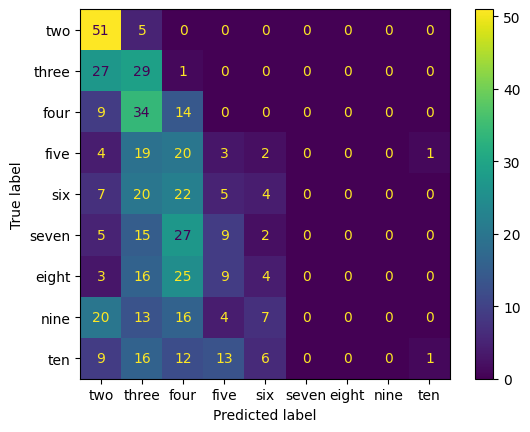

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

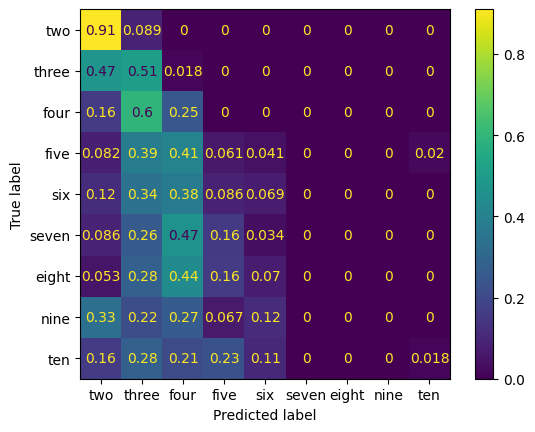

Validation Loss: 0.6112243490633333


Epoch 1/10, Loss: 0.5934:   3%|▎         | 58/2101 [00:15<08:35,  3.96it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:11<00:00,  7.59it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

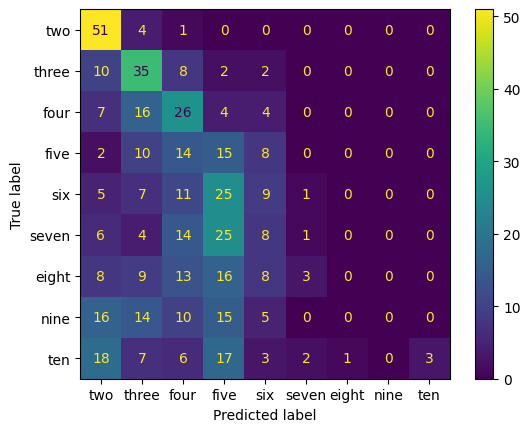

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

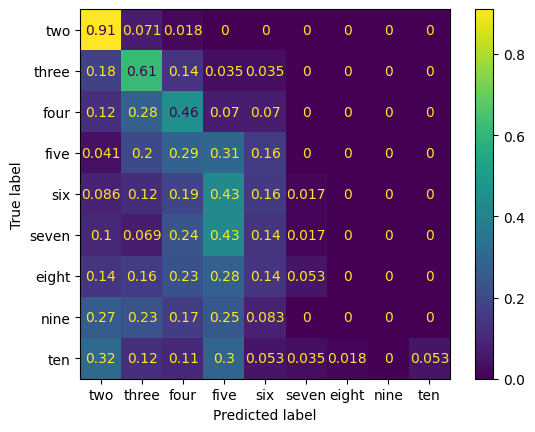

Validation Loss: 0.6040778379694629


Epoch 2/10, Loss: 0.6047:   3%|▎         | 58/2101 [00:15<08:42,  3.91it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:11<00:00,  7.51it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

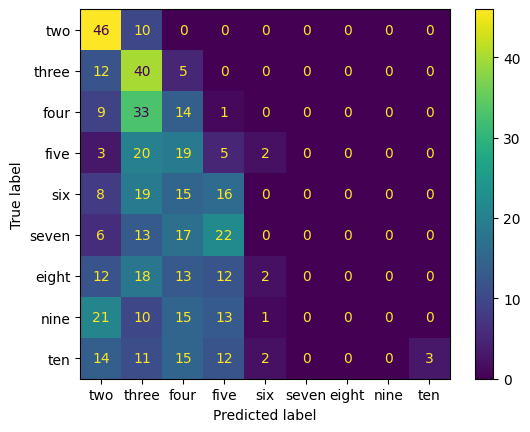

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

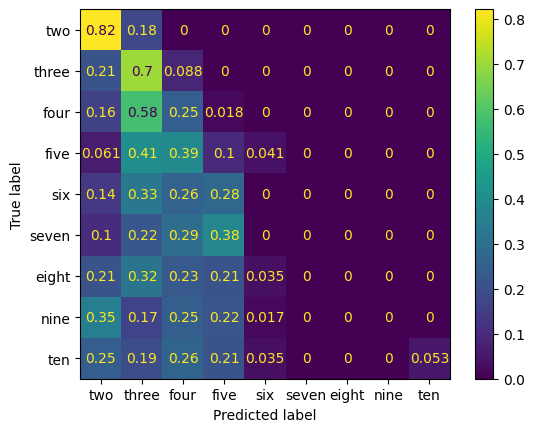

Validation Loss: 0.6126450743340394


Epoch 3/10, Loss: 0.7268:   3%|▎         | 58/2101 [00:15<08:52,  3.84it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.45it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

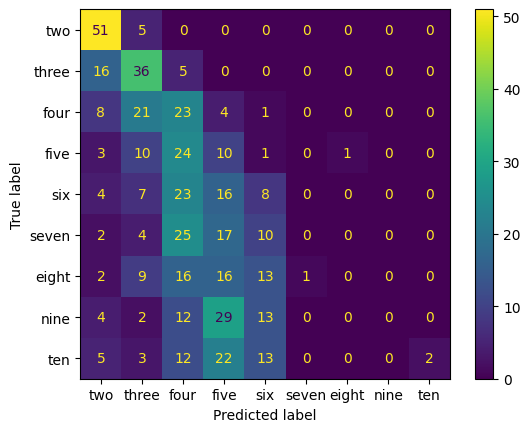

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

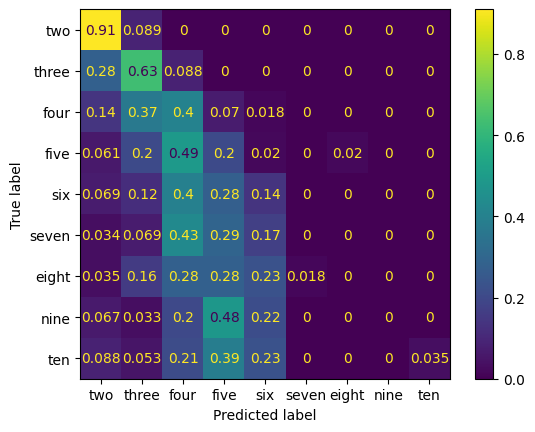

Validation Loss: 0.587456703683959


Epoch 4/10, Loss: 0.5451:   3%|▎         | 58/2101 [00:15<10:25,  3.26it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.40it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

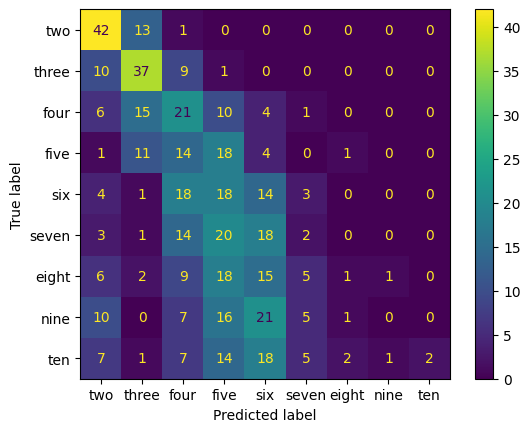

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

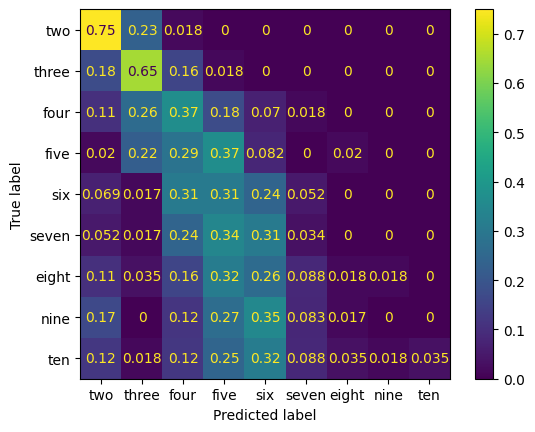

Validation Loss: 0.5852600720572548


Epoch 5/10, Loss: 0.6186:   3%|▎         | 58/2101 [00:15<08:45,  3.88it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.41it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

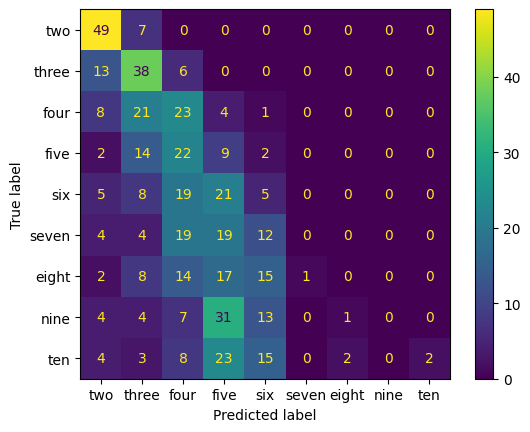

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

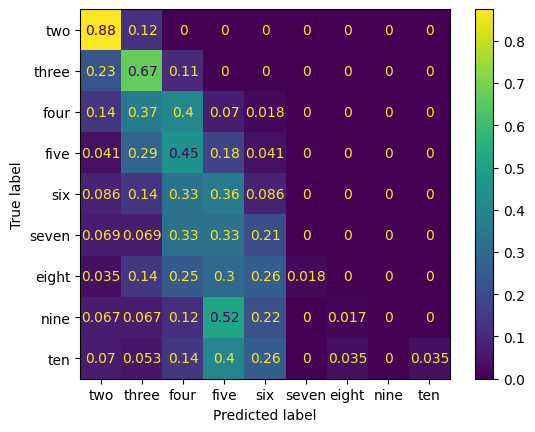

Validation Loss: 0.5920854439211555


Epoch 6/10, Loss: 0.5052:   3%|▎         | 58/2101 [00:15<08:33,  3.98it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.40it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

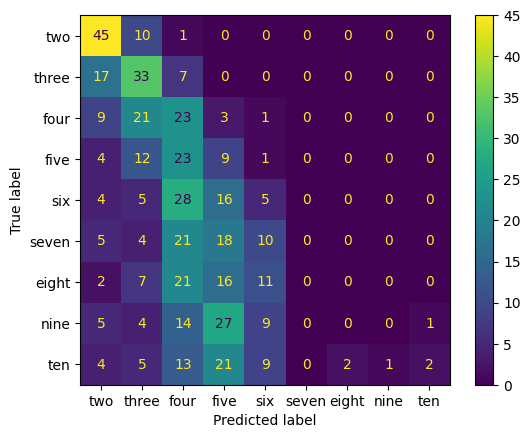

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

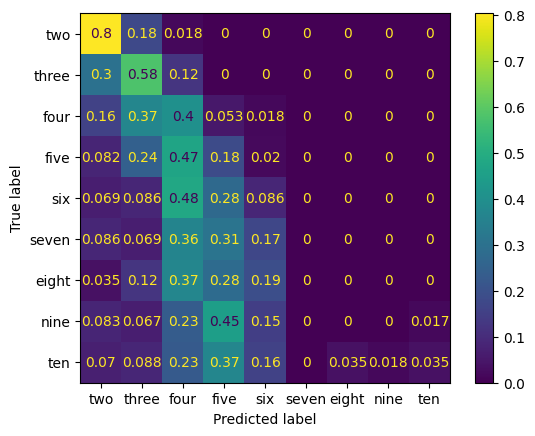

Validation Loss: 0.5936976001801412


Epoch 7/10, Loss: 0.5132:   3%|▎         | 58/2101 [00:15<09:50,  3.46it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:12<00:00,  7.43it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

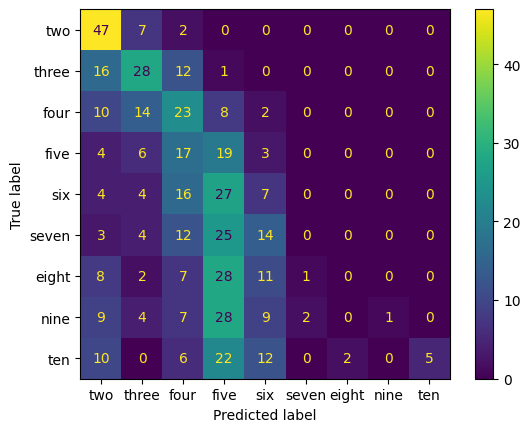

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

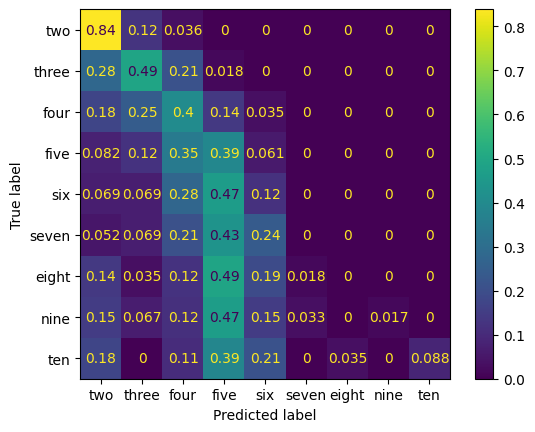

Validation Loss: 0.5910839787795334


Epoch 8/10, Loss: 0.5038:   3%|▎         | 58/2101 [00:15<08:40,  3.93it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.34it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

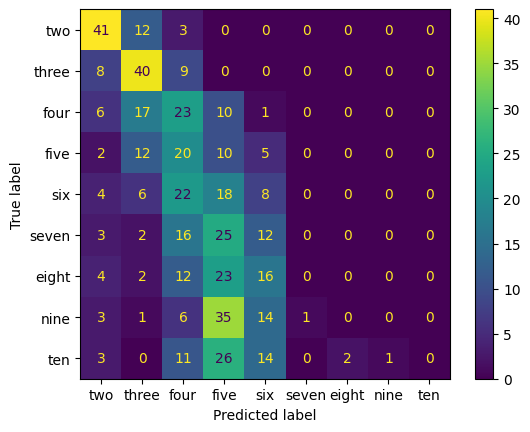

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

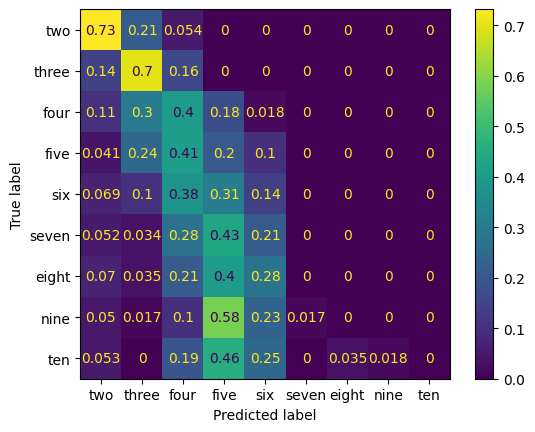

Validation Loss: 0.5997007681063907


Epoch 9/10, Loss: 0.5075:   3%|▎         | 58/2101 [00:15<08:47,  3.87it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.37it/s]


31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

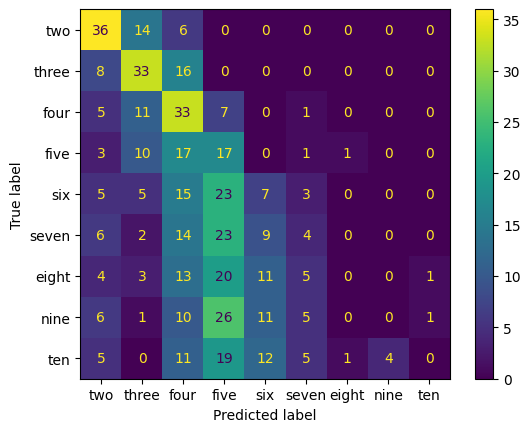

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

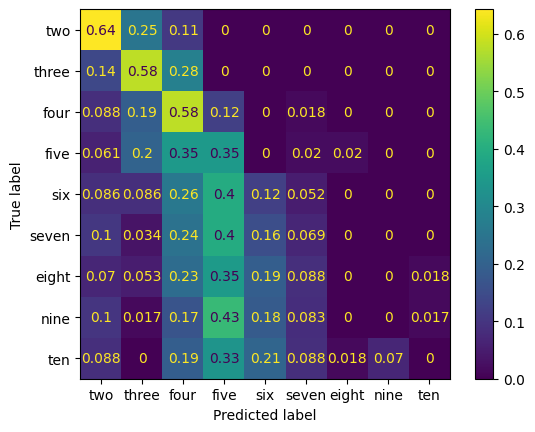

Validation Loss: 0.5899035989974448


In [ ]:
# Train the model
train_arr = []
val_arr = []
num_epochs = 10
lmbda = 1

for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss_arr = []
    val_loss_arr = []

    for batch in pbar:

        optimizer.zero_grad()
        images,texts,cf_texts = batch

        images = images.to(device)
        texts = texts.to(device)
        cf_texts = cf_texts.to(device)

        encoded_imgs = model.encode_image(images)
        encoded_texts = model.encode_text(texts)
        encoded_cf_texts = model.encode_text(torch.unsqueeze(cf_texts[4], 0))

        nc_enc_imgs = encoded_imgs[0:4]
        nc_enc_texts = encoded_texts[0:4]

        c_enc_imgs = encoded_imgs[4:]
        c_enc_texts = encoded_texts[4:]

        ei = c_enc_imgs
        ek = c_enc_texts
        ek_cf = encoded_cf_texts

        counting_loss = count_loss(ei,ek,ek_cf)

        if en_balanced_lambda:
          lmbda = get_lambda(str(texts[4]))

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        train_loss_arr.append(total_loss.item())
        # Backward pass

        total_loss.backward()
        if device == "cpu":
            optimizer.step()
            if en_scheduler:
              scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            if en_scheduler:
              scheduler.step()
            clip.model.convert_weights(model)

        wandb.log({"per_step_train_loss": total_loss.item()})
        wandb.log({"running_train_loss": sum(train_loss_arr)/len(train_loss_arr)})


        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {sum(train_loss_arr)/len(train_loss_arr):.4f}")

    y,y_pred,val_loss,val_acc,f1_scores = get_preds(val_json_path,model)
    val_loss_arr.append(val_loss)
    store_cf(y,y_pred,epoch)
    store_cf_norm(y,y_pred,epoch)

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")
    wandb.log({"per_epoch_val_loss": val_loss})
    wandb.log({"per_epoch_val_acc": val_acc})

    for i in range(len(f1_scores)):
      wandb.log({f"f1_score_class{i}": f1_scores[i]})

    if (epoch+1) % 10 == 0:
      torch.save(model.state_dict(), os.path.join(wandb.run.dir, f"model_{epoch}.pt"))
      torch.save(optimizer.state_dict(), os.path.join(wandb.run.dir, f"optimizer_{epoch}.pt"))
      if en_scheduler:
        torch.save(scheduler.state_dict(), os.path.join(wandb.run.dir, f"scheduler_{epoch}.pt"))


    wandb.log({"per_epoch_loss": np.mean(train_loss_arr)})
    train_arr.append(train_loss_arr)


In [ ]:
wandb.finish()